###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     `987165`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import math

DUD_LABEL = 9999
POSES_NUM = 10

def convert(value):
    try:
        return int(value)
    except:
        try:
            return float(value)
        except:
            return value

def label_dud(value):
    if value in ['','?']:
        return DUD_LABEL
    else:
        return value

def clean(value):
    return convert(value)
#     return convert(label_dud(value))

In [2]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(file_name):
    atts = []
    classes = []
    
    # taken from workshop
    with open(file_name, mode='r') as fin:
        for line in fin:
            all_columns = line.strip().split(",")
            
            # the attributes are the 11 coordinates that come after the class, in each row
            atts_sing = all_columns[1:]
            
            # default string values are cleaned
            for i in range(len(atts_sing)):
                atts_sing[i] = clean(atts_sing[i])
            class_val = clean(all_columns[0])
            
            # append each line into their respective lists
            classes.append(class_val)
            atts.append(atts_sing)
    
    return {'atts': atts, 'classes': classes}

In [3]:
# This function should calculat prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(train_atts, train_classes):
    class_freq = defaultdict(int)
    class_priors = {}
    mean_sd_array = {}
    entries_by_label = {}
    instances = 0
    
    train_rows = len(train_atts)
    
    # taken from workshop
    for class_inst in train_classes:
        instances += 1
        class_freq[class_inst] += 1
    # taken from workshop
    
    for lbl in class_freq.keys():
        # making class_priors
        class_priors[lbl] = class_freq[lbl] / instances
        
        # making mean_sd_array
        mean_sd_array[lbl] = {}
        
    for lbl in class_freq.keys():
        entries_by_label[lbl] = []
        for row in range(train_rows):
            if train_classes[row] == lbl:
                entries_by_label[lbl].append(train_atts[row])
    
    mean_sd_array = find_mean_sd('mean', class_priors, entries_by_label, mean_sd_array)
    mean_sd_array = find_mean_sd('sd', class_priors, entries_by_label, mean_sd_array)        
    return {'class_priors': class_priors, 'mean_sd_array': mean_sd_array}

In [4]:
def find_mean_sd(mean_or_sd, class_priors, entries_by_label, mean_sd_array):
    for lbl in class_priors.keys():
        rows_sub = len(entries_by_label[lbl])
        cols_sub = len(entries_by_label[lbl][0])
        for col in range(cols_sub):
            if mean_or_sd == 'mean':
                mean_sd_array[lbl][col] = [0.0, 0.0]
                mean = 0.0
            elif mean_or_sd == 'sd':
                sd = 0.0
            count = 0
            for row in range(rows_sub):
                plucked_value = entries_by_label[lbl][row][col]
                # if the picked value is not a dud
                if plucked_value != DUD_LABEL:
                    if mean_or_sd == 'mean':
                        mean += plucked_value
                    elif mean_or_sd == 'sd':
                        mean = mean_sd_array[lbl][col][0]
                        sd += math.pow(entries_by_label[lbl][row][col] - mean, 2)    
                    count += 1
            # insufficient data to calculate a mean or sd
            if count == 0 or count == 1:
                mean_sd_array[lbl][col][0] = 0
                mean_sd_array[lbl][col][1] = 0
            else:
                if mean_or_sd == 'mean':
                    mean_sd_array[lbl][col][0] = mean / count
                elif mean_or_sd == 'sd':
                    mean_sd_array[lbl][col][1] = math.sqrt(sd / (count - 1))
    return mean_sd_array

In [5]:
# This function should predict classes for new items in a test dataset

def predict(test_atts, class_priors, mean_sd_array):
    prediction = [] # prediction output list
    class_probabilities = []
    
    rows = len(test_atts)
    cols = len(test_atts[0])
    
    for row in range(rows):
        class_probabilities.append({})
        for lbl in class_priors.keys():
            sum = math.log(class_priors[lbl])
            for col in range(cols):
                if test_atts[row][col] != DUD_LABEL:
                    # some likelihoods cannot be calculated because the training data had
                    # too many missing features to calculate a gaussian mean and sd.
                    if mean_sd_array[lbl][col][1] != 0:
                        # some probabilities are too small for the log, thereby necessitating
                        # this try and except
                        try:
                            sum = sum + math.log(calculate_pdf(test_atts[row][col], mean_sd_array[lbl][col][0], mean_sd_array[lbl][col][1]))
                        except:
                            pass
            class_probabilities[row][lbl] = sum
    
    for class_set in class_probabilities:
        max_class = ''
        max_prob = -9999999

        # compares probabilities to find the highest one
        for lbl in class_set.keys():
            current_prob = class_set[lbl]
            if current_prob > max_prob:
                max_prob = current_prob
                max_class = lbl
        prediction.append(max_class)
    return prediction

In [6]:
# calculates a pdf given the normal assumption
def calculate_pdf(x_value, mean, sd):
    try:
        return (1 / (sd * math.sqrt(2 * math.pi))) * math.pow(math.e, -1/2 * math.pow((x_value - mean) / sd, 2))
    except ZeroDivisionError:
        calculate_pdf(x_value, mean, 0.1)

In [7]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

# essentially, this function finds the accuracy
def evaluate(prediction, test_classes):
    correct_count = 0
    rows = len(prediction)
    
    for row in range(rows):
        if prediction[row] == test_classes[row]:
            correct_count = correct_count + 1
            
    return correct_count / rows

## Basic Classifier Implementation

In [8]:
training_data = preprocess("train.csv")
testing_data = preprocess("test.csv")

probability_data = train(training_data['atts'], training_data['classes'])

myprediction = predict(testing_data['atts'], probability_data['class_priors'], probability_data['mean_sd_array'])

evaluation_data = evaluate(myprediction, testing_data['classes'])

print("accuracy is", evaluation_data)

accuracy is 0.7155172413793104


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1 Model Evaluation
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [9]:
# this constructs the actual vs predicted array
def return_actual_vs_predicted(actual_classes, predicted_classes):
    # creating our 2D array, ready to be filled
    actual_vs_predicted = []
    initialised_row = []
    for i in range(POSES_NUM):
        initialised_row.append(0)
    
    poses_names = ["bridge", "childs", "downwarddog", "mountain", "plank", "seatedforwardbend", "tree", "trianglepose", "warrior1", "warrior2"]

    for i in range(POSES_NUM):
        actual_vs_predicted.append(initialised_row.copy())

    for myindex, actual_class in enumerate(actual_classes):
        try:
            row_number = poses_names.index(actual_class)
        except:
            print("unexpected actual class")
        
        predicted_class = predicted_classes[myindex]
        
        try:
            col_number = poses_names.index(predicted_class)
        except:
            print("unexpected predicted class")
        
        # this iterates through and counts the instances
        actual_vs_predicted[row_number][col_number] += 1
    return actual_vs_predicted

[[5, 3, 5, 0, 1, 0, 0, 0, 0, 0], [0, 11, 0, 1, 0, 1, 0, 0, 0, 0], [1, 1, 13, 3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 26, 0, 0, 4, 0, 0, 0], [2, 0, 0, 0, 6, 0, 0, 1, 0, 0], [0, 3, 1, 0, 0, 4, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0, 3, 0, 2, 0], [0, 0, 0, 0, 0, 0, 0, 4, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 4, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 7]]


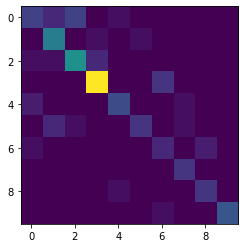

   0   1   2   3  4  5  6  7  8  9
0  5   3   5   0  1  0  0  0  0  0
1  0  11   0   1  0  1  0  0  0  0
2  1   1  13   3  0  0  0  0  0  0
3  0   0   0  26  0  0  4  0  0  0
4  2   0   0   0  6  0  0  1  0  0
5  0   3   1   0  0  4  0  1  0  0
6  1   0   0   0  0  0  3  0  2  0
7  0   0   0   0  0  0  0  4  0  0
8  0   0   0   0  1  0  0  0  4  0
9  0   0   0   0  0  0  1  0  0  7


In [10]:
import matplotlib.pyplot as plt

myactual_vs_predicted = return_actual_vs_predicted(testing_data['classes'], myprediction)
print(myactual_vs_predicted)

# better visualisations below
plt.imshow(myactual_vs_predicted)
plt.show()

print(pd.DataFrame(myactual_vs_predicted))

In [11]:
def precision_macro(actual_vs_predicted):
    precisions_list = []
    for i in range(POSES_NUM):
        precisions_list.append(0)
        
    for pose_number in range(POSES_NUM):
        tp = actual_vs_predicted[pose_number][pose_number]
        fp = 0
        for myrow_num, myrow in enumerate(actual_vs_predicted):
            if myrow_num != pose_number:
                fp += myrow[pose_number]
        precisions_list[pose_number] = tp / (tp + fp)
    
    return sum(precisions_list) / POSES_NUM

In [12]:
myprecision_macro = precision_macro(myactual_vs_predicted)
print(myprecision_macro)

0.6975877192982457


In [13]:
def precision_micro(actual_vs_predicted):
    tp_list = []
    fp_list = []
        
    for pose_number in range(POSES_NUM):
        tp = actual_vs_predicted[pose_number][pose_number]
        fp = 0
        for myrow_num, myrow in enumerate(actual_vs_predicted):
            if myrow_num != pose_number:
                fp += myrow[pose_number]
        tp_list.append(tp)
        fp_list.append(fp)
    denom = [a_i + b_i for a_i, b_i in zip(tp_list, fp_list)]
    return sum(tp_list) / sum(denom)

In [14]:
myprecision_micro = precision_micro(myactual_vs_predicted)
print(myprecision_micro)

0.7155172413793104


In [15]:
def recall_macro(actual_vs_predicted):
    recalls_list = []
    for i in range(POSES_NUM):
        recalls_list.append(0)
        
    for pose_number in range(POSES_NUM):
        tp = actual_vs_predicted[pose_number][pose_number]
        fn = 0
        
        myrow = actual_vs_predicted[pose_number]
        
        for myindex, count in enumerate(myrow):
            if myindex != pose_number:
                fn += count

        recalls_list[pose_number] = tp / (tp + fn)
    
    return sum(recalls_list) / POSES_NUM

In [16]:
myrecall_macro = recall_macro(myactual_vs_predicted)
print(myrecall_macro)

0.7078296703296703


In [17]:
def recall_micro(actual_vs_predicted):
    tp_list = []
    fn_list = []
        
    for pose_number in range(POSES_NUM):
        tp = actual_vs_predicted[pose_number][pose_number]
        fn = 0
        
        myrow = actual_vs_predicted[pose_number]
        
        for myindex, count in enumerate(myrow):
            if myindex != pose_number:
                fn += count
        tp_list.append(tp)
        fn_list.append(fn)
    denom = [a_i + b_i for a_i, b_i in zip(tp_list, fn_list)]
    return sum(tp_list) / sum(denom)

In [18]:
myrecall_micro = recall_micro(myactual_vs_predicted)
print(myrecall_micro)

0.7155172413793104


In [19]:
def f_score_calc(beta, precision, recall):
    beta_squared = math.pow(beta, 2)
    return ((1 + beta_squared) * precision * recall) / (beta_squared * precision + recall)

In [20]:
fscore_macro = f_score_calc(1, myprecision_macro, myrecall_macro)
fscore_micro = f_score_calc(1, myprecision_micro, myrecall_micro)

print(fscore_macro)
print(fscore_micro)

0.7026713758076242
0.7155172413793104


### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.

### Part 1 - Using both Gradients and Lengths

In [21]:
def give_gradients_distances_2D(my_data):
    whole_2D_array = []
    for my_row in my_data['atts']:
        my_gradients_distances = []
        for body_part_number in range(10):
            x1 = my_row[2 * body_part_number]
            y1 = my_row[2 * body_part_number + 1]
            x2 = my_row[2 * body_part_number + 2]
            y2 = my_row[2 * body_part_number + 3]
            if x1 != DUD_LABEL and y1 != DUD_LABEL and x2 != DUD_LABEL and y2 != DUD_LABEL:
                x_diff = x2 - x1
                if x_diff != 0:
                    my_gradient = (y2 - y1) / (x2 - x1)
                else:
                    # if two points are on top of each other, set their gradients to be very high
                    my_gradient = 9999999
                a = [x1, y1]
                b = [x2, y2]
                jesuschrist = [a_i - b_i for a_i, b_i in zip(a, b)]
                my_distance = np.linalg.norm(jesuschrist)
            else:
                my_gradient = DUD_LABEL
                my_distance = DUD_LABEL
            my_gradients_distances.append(my_gradient)
            my_gradients_distances.append(my_distance)
        whole_2D_array.append(my_gradients_distances)
    return whole_2D_array

In [22]:
processed_test_data = give_gradients_distances_2D(testing_data)
processed_training_data = give_gradients_distances_2D(training_data)

### Part 2 - Using Only Gradients

In [23]:
def give_gradients_2D(my_data):
    whole_2D_array = []
    for my_row in my_data['atts']:
        my_gradients = []
        for body_part_number in range(10):
            x1 = my_row[2 * body_part_number]
            y1 = my_row[2 * body_part_number + 1]
            x2 = my_row[2 * body_part_number + 2]
            y2 = my_row[2 * body_part_number + 3]
            if x1 != DUD_LABEL and y1 != DUD_LABEL and x2 != DUD_LABEL and y2 != DUD_LABEL:
                x_diff = x2 - x1
                if x_diff != 0:
                    my_gradient = (y2 - y1) / (x2 - x1)
                else:
                    # if two points are on top of each other, set their gradients to be very high
                    my_gradient = 9999999
            else:
                my_gradient = DUD_LABEL
            my_gradients.append(my_gradient)
        whole_2D_array.append(my_gradients)
    return whole_2D_array

In [24]:
processed_test_data = give_gradients_2D(testing_data)
processed_training_data = give_gradients_2D(training_data)

### Common Final Execution for Part 1 and 2

In [25]:
# test instances with not a single feature able to be engineered are assigned the basic
# classifier's prediction (placeholder: KLAI8273)
basic_classifier_override = []

for myindex, myrow in enumerate(processed_test_data):
    replace_row = 1
    for my_value in myrow:
        if my_value != DUD_LABEL:
            replace_row = 0
    
    if replace_row == 1:
        basic_classifier_override.append(myprediction[myindex])
    else:
        basic_classifier_override.append(DUD_LABEL)

probability_data2 = train(processed_training_data, training_data['classes'])
myprediction2 = predict(processed_test_data, probability_data2['class_priors'], probability_data2['mean_sd_array'])

# myprediction2 has some predictions overriden (see placeholder KLAI8273 for details)
for my_index, prediction in enumerate(basic_classifier_override):
    if prediction != DUD_LABEL:
        myprediction2[my_index] = prediction

evaluation_data = evaluate(myprediction2, testing_data['classes'])

"""
print(myprediction2)
print(testing_data['classes'])

for prediction_index in range(len(myprediction2)):
    if testing_data['classes'][prediction_index] == myprediction2[prediction_index]:
        print("True")
    else:
        print("False")
"""

print("accuracy is", evaluation_data)

accuracy is 0.4396551724137931
